<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep9-eda-modeling?scriptVersionId=120854098" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#Notebook-Versions)

[2. Loading Libraries](#Loading-Libraries)

[3. Reading Data Files](#Reading-Data-Files)

[4. Data Description](#Data-Description)

[5. Data Exploration](#Data-Exploration)

[6. Baseline 1.0](#Baseline-1.0)

[7. Baseline 2.0](#Baseline-2.0)

[8. Baseline 3.0](#Baseline-3.0)

[9. Baseline 3.5](#Baseline-3.5)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

1. Version 1 (02/27/2023)
    * EDA 
    * Baseline 1.0

2. Version 2 (02/28/2023)
    * Adding correlation heatmap of test
    * Updated baseline 1.0
    
3. Version 3 (02/28/2023)
    * Saving individual model results
    
4. Version 4 (02/28/2023)
    * Baseline 2.0 added

5. Version 5 (03/01/2023)
    * Baseline 3.0 added
    
6. Version 6 (03/01/2023)
    * Fixing bug
    
7. Version 7 (03/02/2023)
    * Baseline 3.5 added

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, SVR
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
train = pd.read_csv('../input/playground-series-s3e9/train.csv')
test = pd.read_csv('../input/playground-series-s3e9/test.csv')
submission = pd.read_csv('../input/playground-series-s3e9/sample_submission.csv')

print('The dimession of the train dataset is:', train.shape)
print('The dimession of the test dataset is:', test.shape)

The dimession of the train dataset is: (5407, 10)
The dimession of the test dataset is: (3605, 9)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5407 entries, 0 to 5406
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         5407 non-null   int64  
 1   CementComponent            5407 non-null   float64
 2   BlastFurnaceSlag           5407 non-null   float64
 3   FlyAshComponent            5407 non-null   float64
 4   WaterComponent             5407 non-null   float64
 5   SuperplasticizerComponent  5407 non-null   float64
 6   CoarseAggregateComponent   5407 non-null   float64
 7   FineAggregateComponent     5407 non-null   float64
 8   AgeInDays                  5407 non-null   int64  
 9   Strength                   5407 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 422.5 KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3605 entries, 0 to 3604
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         3605 non-null   int64  
 1   CementComponent            3605 non-null   float64
 2   BlastFurnaceSlag           3605 non-null   float64
 3   FlyAshComponent            3605 non-null   float64
 4   WaterComponent             3605 non-null   float64
 5   SuperplasticizerComponent  3605 non-null   float64
 6   CoarseAggregateComponent   3605 non-null   float64
 7   FineAggregateComponent     3605 non-null   float64
 8   AgeInDays                  3605 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 253.6 KB


In [5]:
train.head()

id  CementComponent  BlastFurnaceSlag  FlyAshComponent  WaterComponent  \
0   0            525.0               0.0              0.0           186.0   
1   1            143.0             169.0            143.0           191.0   
2   2            289.0             134.7              0.0           185.7   
3   3            304.0              76.0              0.0           228.0   
4   4            157.0             236.0              0.0           192.0   

   SuperplasticizerComponent  CoarseAggregateComponent  \
0                        0.0                    1125.0   
1                        8.0                     967.0   
2                        0.0                    1075.0   
3                        0.0                     932.0   
4                        0.0                     935.4   

   FineAggregateComponent  AgeInDays  Strength  
0                   613.0          3     10.38  
1                   643.0         28     23.52  
2                   795.3         28     36.96  
3                   670.0        365     39.05  
4                   781.2         90     74.19

In [6]:
train.describe()

id  CementComponent  BlastFurnaceSlag  FlyAshComponent  \
count  5407.000000      5407.000000       5407.000000      5407.000000   
mean   2703.000000       299.168189         58.610579        31.872795   
std    1561.010784       105.537682         83.417801        54.605003   
min       0.000000       102.000000          0.000000         0.000000   
25%    1351.500000       213.700000          0.000000         0.000000   
50%    2703.000000       297.200000          0.000000         0.000000   
75%    4054.500000       375.000000        122.600000        79.000000   
max    5406.000000       540.000000        359.400000       200.100000   

       WaterComponent  SuperplasticizerComponent  CoarseAggregateComponent  \
count     5407.000000                5407.000000               5407.000000   
mean       185.076235                   4.108441                992.000718   
std         18.517583                   5.692296                 77.148010   
min        121.800000                   0.000000                801.000000   
25%        175.100000                   0.000000                938.200000   
50%        187.400000                   0.000000                978.000000   
75%        192.000000                   8.050000               1047.000000   
max        247.000000                  32.200000               1145.000000   

       FineAggregateComponent    AgeInDays     Strength  
count             5407.000000  5407.000000  5407.000000  
mean               771.219974    51.751618    35.452071  
std                 78.725253    70.006975    16.401896  
min                594.000000     1.000000     2.330000  
25%                734.300000     7.000000    23.640000  
50%                781.200000    28.000000    33.950000  
75%                821.000000    56.000000    45.850000  
max                992.600000   365.000000    82.600000

In [7]:
test.head()

id  CementComponent  BlastFurnaceSlag  FlyAshComponent  WaterComponent  \
0  5407            166.1              75.4            163.8           173.8   
1  5408            304.0               0.0              0.0           190.0   
2  5409            225.0               0.0              0.0           185.0   
3  5410            251.4               0.0            118.3           188.5   
4  5411            144.0              15.0            195.0           176.0   

   SuperplasticizerComponent  CoarseAggregateComponent  \
0                        4.6                    1007.2   
1                        0.0                     998.0   
2                        0.0                    1113.0   
3                        6.4                    1028.4   
4                        6.0                    1021.0   

   FineAggregateComponent  AgeInDays  
0                   746.6         56  
1                   801.0          7  
2                   833.0         28  
3                   757.7        100  
4                   709.0         28

In [8]:
test.describe()

id  CementComponent  BlastFurnaceSlag  FlyAshComponent  \
count  3605.000000      3605.000000       3605.000000      3605.000000   
mean   7209.000000       299.943523         55.803273        32.829154   
std    1040.818188       104.809283         80.938863        55.490684   
min    5407.000000       102.000000          0.000000         0.000000   
25%    6308.000000       213.800000          0.000000         0.000000   
50%    7209.000000       300.000000          0.000000         0.000000   
75%    8110.000000       374.000000        117.200000        90.000000   
max    9011.000000       540.000000        359.400000       200.100000   

       WaterComponent  SuperplasticizerComponent  CoarseAggregateComponent  \
count     3605.000000                3605.000000               3605.000000   
mean       184.345825                   4.194230                990.222330   
std         17.964842                   5.807567                 76.812197   
min        121.800000                   0.000000                801.000000   
25%        174.900000                   0.000000                938.200000   
50%        188.500000                   0.000000                977.600000   
75%        192.000000                   8.100000               1047.000000   
max        247.000000                  32.200000               1145.000000   

       FineAggregateComponent    AgeInDays  
count             3605.000000  3605.000000  
mean               774.736311    49.153398  
std                 77.412505    63.564334  
min                594.000000     1.000000  
25%                739.300000     7.000000  
50%                781.500000    28.000000  
75%                821.000000    56.000000  
max                992.600000   365.000000

> <div class="alert alert-block alert-info">
<b>💡</b> There are no missing values neither in the train nor test datasets. Also, by a quick eye-ball comparison of the summary statistics of the train and test datasets, they seem to have similar distributions. 
</div>

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Description</h1>

This is a synthetic dataset generated from the [Concrete Strength Prediction](https://www.kaggle.com/datasets/mchilamwar/predict-concrete-strength) dataset. These are the descriptions of the variables in this dataset:

<ul>
    <li> id: unique identifier of each observation. </li>
    <li> CementComponent: Amount of cement is mixed. </li>
    <li> BlastFurnaceSlag: Amount of Blast Furnace Slag is mixed. </li>
    <li> FlyAshComponent: Amount of FlyAsh is mixed. </li>
    <li> WaterComponent: Amount of water is mixed.  </li>
    <li> SuperplasticizerComponent: Amount of Super plasticizer is mixed. </li>
    <li> CoarseAggregateComponent: Amount of Coarse Aggregate is mixed. </li>
    <li> FineAggregateComponent: Amount of Coarse Aggregate is mixed. </li>
    <li> AgeInDays: How many days it was left dry. </li>
    <li> Strength: What was the final strength of concrete. </li>
</ul>


<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1> 

First, we take a quick look at the pair-wise plots.

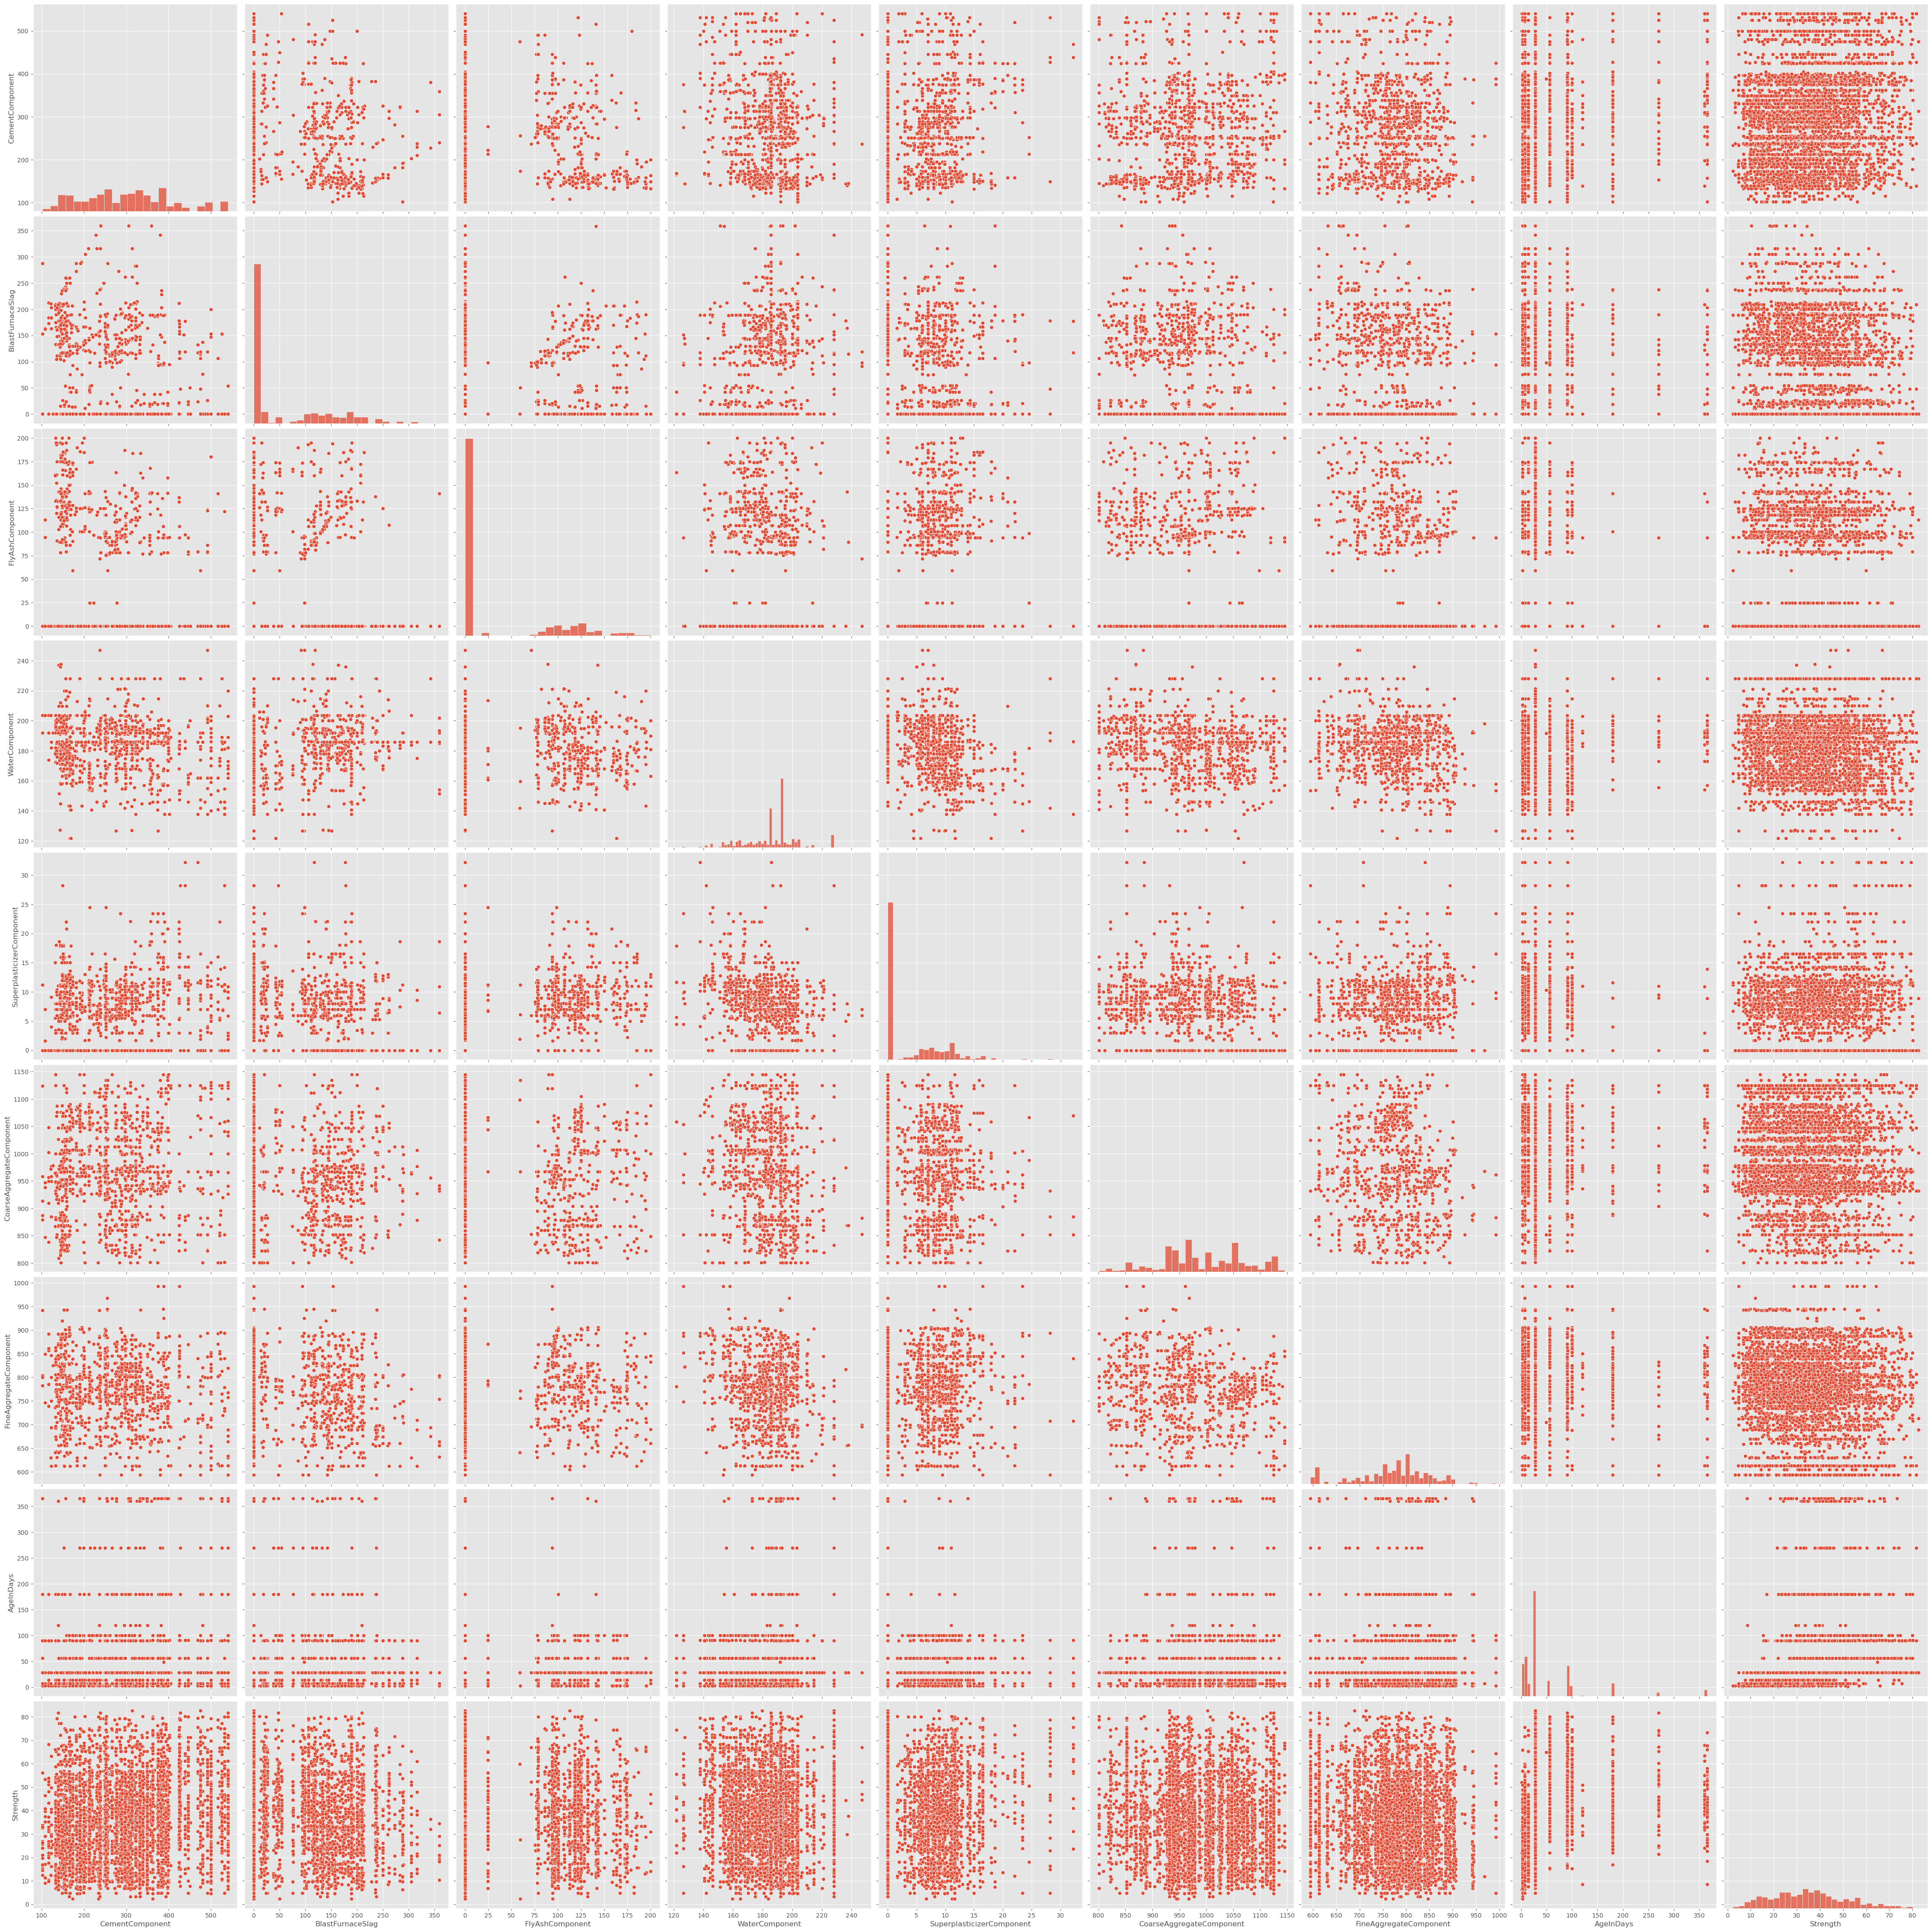

In [9]:
sns.pairplot(train.drop(columns = ['id'], axis = 1), height = 5);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above charts, it seems that there is no strong relationships among the features and the target. 
</div>

Let's take a closer look at the correlation heatmap.

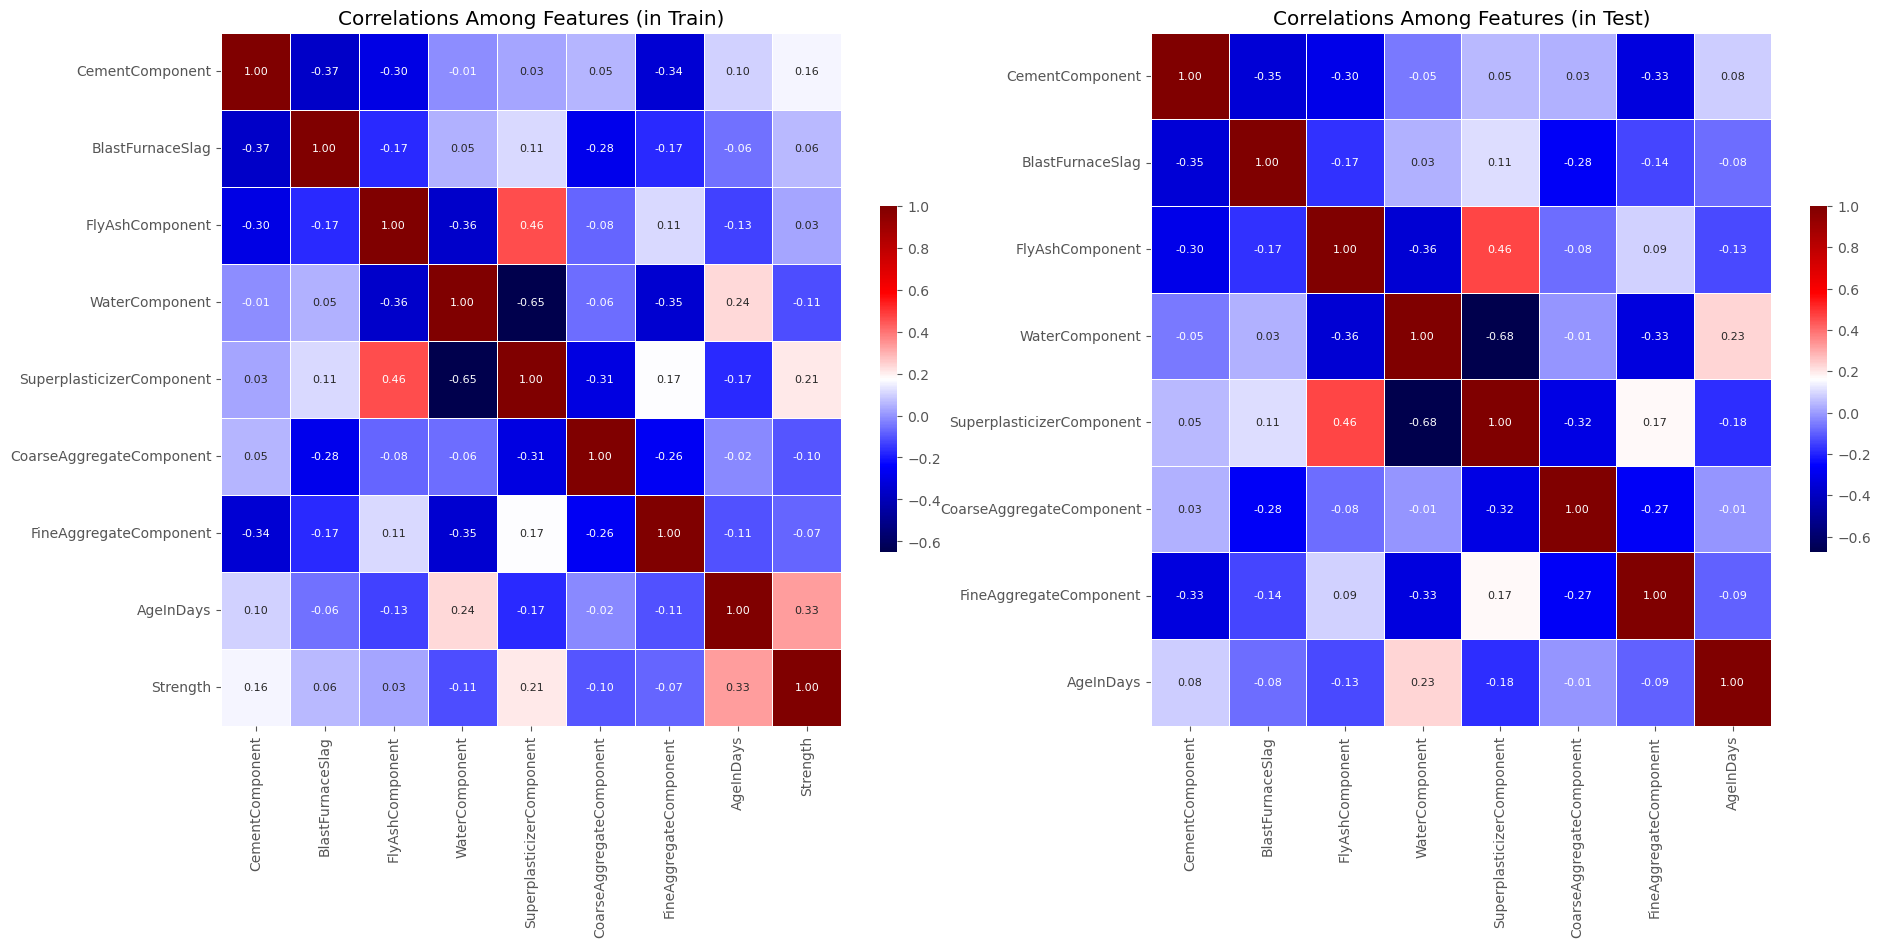

In [10]:
corr_mat_train = train.drop(columns = ['id'], axis = 1).corr()
corr_mat_test = test.drop(columns = ['id'], axis = 1).corr()

fig, axes = plt.subplots(1, 2, figsize = (22, 9))
sns.heatmap(corr_mat_train, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[0]).set_title('Correlations Among Features (in Train)')
sns.heatmap(corr_mat_test, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Features (in Test)');

> <div class="alert alert-block alert-info">
<b>💡</b> From the above charts, there is weak correlation between AgeInDays and Strength, and SuperplasticizerComponent and Strength. Also, the correlation among the features are roughly the same in the train and test datasets.
</div>

Next, we compare the distribution of the train and test datasets.

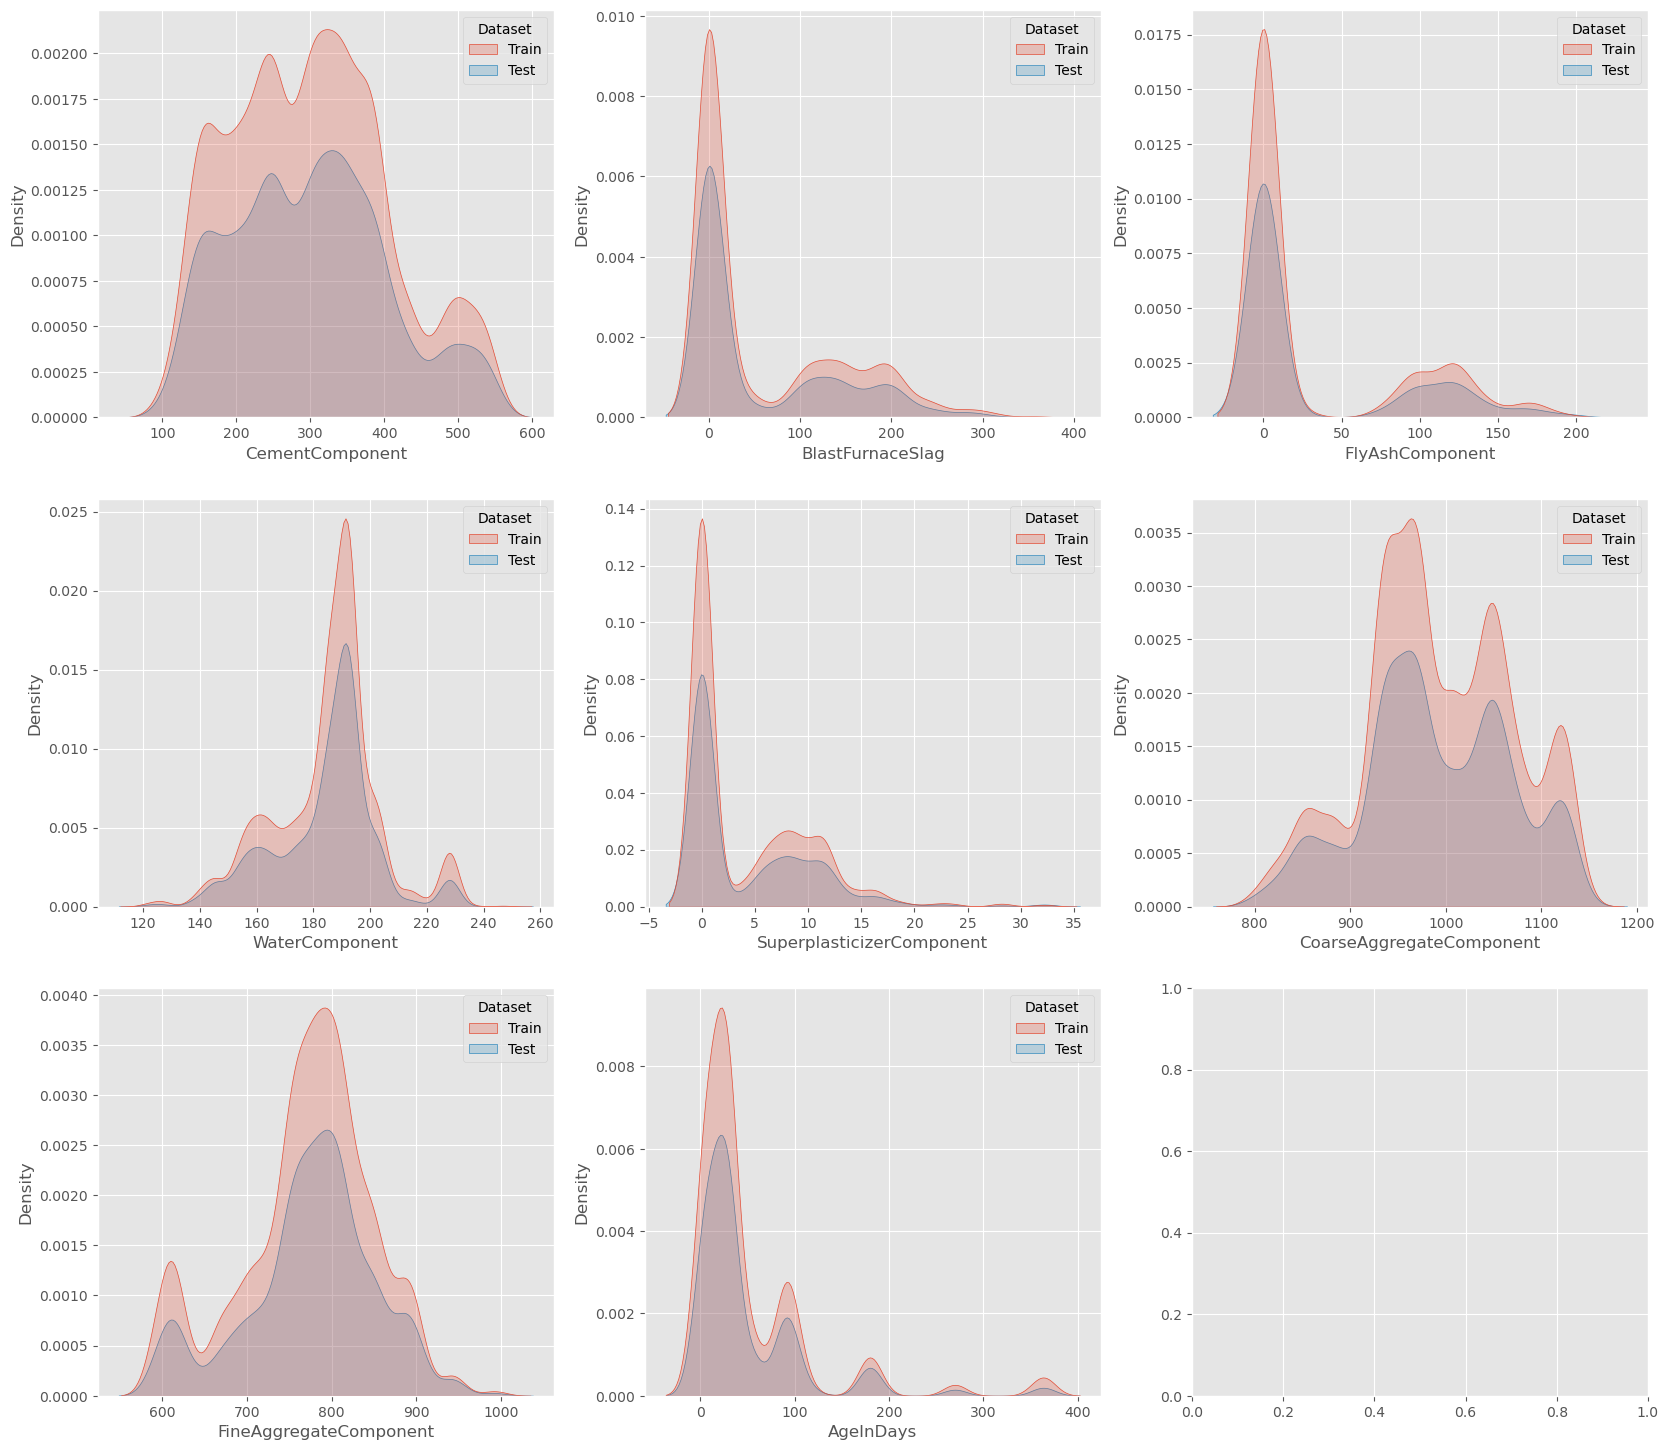

In [11]:
train_vis = train.drop(columns = ['id', 'Strength'], axis = 1).reset_index(drop = True).copy()
test_vis = test.copy()

train_vis['Dataset'] = 'Train'
test_vis['Dataset'] = 'Test'
data_tot = pd.concat([train_vis, test_vis], axis = 0).reset_index(drop = True)

fig, axes = plt.subplots(3, 3, figsize = (20, 18))

sns.kdeplot(ax = axes[0, 0], x = 'CementComponent', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'BlastFurnaceSlag', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'FlyAshComponent', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'WaterComponent', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'SuperplasticizerComponent', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'CoarseAggregateComponent', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[2, 0], x = 'FineAggregateComponent', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[2, 1], x = 'AgeInDays', hue = 'Dataset', data = data_tot, fill = True);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above density plots, we see that the distributions of the features are very similar in the train and test datasets. 
</div>

We next take a close look in the train and test dataset. In particular, we inpect both dataset for duplicates.

In [12]:
print('There are ', train.shape[0], ' observations in the train datset')
print('There are ', train.drop(columns = ['id', 'Strength'], axis = 1).drop_duplicates().shape[0], ' observations in the train datset')

There are  5407  observations in the train datset
There are  3006  observations in the train datset


In [13]:
print('There are ', test.shape[0], ' observations in the test datset')
print('There are ', test.drop(columns = ['id'], axis = 1).drop_duplicates().shape[0], ' observations in the test datset')

There are  3605  observations in the test datset
There are  2254  observations in the test datset


In [14]:
train_dup = train.drop(columns = ['id', 'Strength'], axis = 1).drop_duplicates()
test_dup = test.drop(columns = ['id'], axis = 1).drop_duplicates()
duplicates = pd.merge(train_dup, test_dup, on = train_dup.columns.tolist()[0:9])

print('There are ', duplicates.shape[0], ' rows that appear in the train and test dataset.\n')

There are  651  rows that appear in the train and test dataset.



<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline 1.0</h1>

In this section, we build a xgboost, lightgbm, and catboost models with raw features.

In [15]:
X = train.drop(columns = ['id', 'Strength'], axis = 1)
Y = train['Strength']

test_baseline = test.drop(columns = ['id'], axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
XGB_preds = list()

lgb_cv_scores, lgb_imp = list(), list()
lgb_preds = list()

cat_cv_scores, cat_imp = list(), list()
cat_preds = list()

for i in range(5):

    skf = KFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        #############    
        ## XGBoost ##
        #############
        
        XGB_md = XGBRegressor(tree_method = 'gpu_hist',
                              colsample_bytree = 0.7, 
                              gamma = 0.8, 
                              learning_rate = 0.01, 
                              max_depth = 7, 
                              min_child_weight = 10, 
                              n_estimators = 1000, 
                              subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test_baseline)
        
        ## Computing rmse
        XGB_cv_scores.append(mean_squared_error(Y_test, XGB_pred_1, squared = False))
        XGB_preds.append(XGB_pred_2)
        
        ##############
        ## LightGBM ##
        ##############
        
        lgb_md = LGBMRegressor(n_estimators = 1000,
                               max_depth = 7,
                               learning_rate = 0.01,
                               num_leaves = 20,
                               lambda_l1 = 3,
                               lambda_l2 = 3,
                               bagging_fraction = 0.7,
                               feature_fraction = 0.7, 
                               device = 'gpu').fit(X_train, Y_train)
        lgb_imp.append(lgb_md.feature_importances_)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict(X_test)
        lgb_pred_2 = lgb_md.predict(test_baseline)
        
        ## Computing rmse
        lgb_cv_scores.append(mean_squared_error(Y_test, lgb_pred_1, squared = False))
        lgb_preds.append(lgb_pred_2)
        
        ##############
        ## CatBoost ##
        ##############
        
        cat_md = CatBoostRegressor(loss_function = 'RMSE',
                                   iterations = 1000,
                                   learning_rate = 0.01,
                                   depth = 7,
                                   random_strength = 0.5,
                                   bagging_temperature = 0.7,
                                   border_count = 30,
                                   l2_leaf_reg = 5,
                                   verbose = False, 
                                   task_type = 'GPU').fit(X_train, Y_train)
        cat_imp.append(cat_md.feature_importances_)
        
        ## Predicting on X_test and test
        cat_pred_1 = cat_md.predict(X_test)
        cat_pred_2 = cat_md.predict(test_baseline)
        
        ## Computing rmse
        cat_cv_scores.append(mean_squared_error(Y_test, cat_pred_1, squared = False))
        cat_preds.append(cat_pred_2)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[Li

In [16]:
XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average oof rmse score over 5-folds (run 5 times) of the XGBoost model is:', XGB_cv_score)

lgb_cv_score = np.mean(lgb_cv_scores)    
print('The average oof rmse score over 5-folds (run 5 times) of the LightGBM model is:', lgb_cv_score)

cat_cv_score = np.mean(cat_cv_scores)    
print('The average oof rmse score over 5-folds (run 5 times) of the CatBoost model is:', cat_cv_score)

The average oof rmse score over 5-folds (run 5 times) of the XGBoost model is: 12.297465003471464
The average oof rmse score over 5-folds (run 5 times) of the LightGBM model is: 12.20038653379661
The average oof rmse score over 5-folds (run 5 times) of the CatBoost model is: 12.062858853778268


We next proceed to visualize the importance of the features under the XGBoost, LightGBM and CatBoost models.

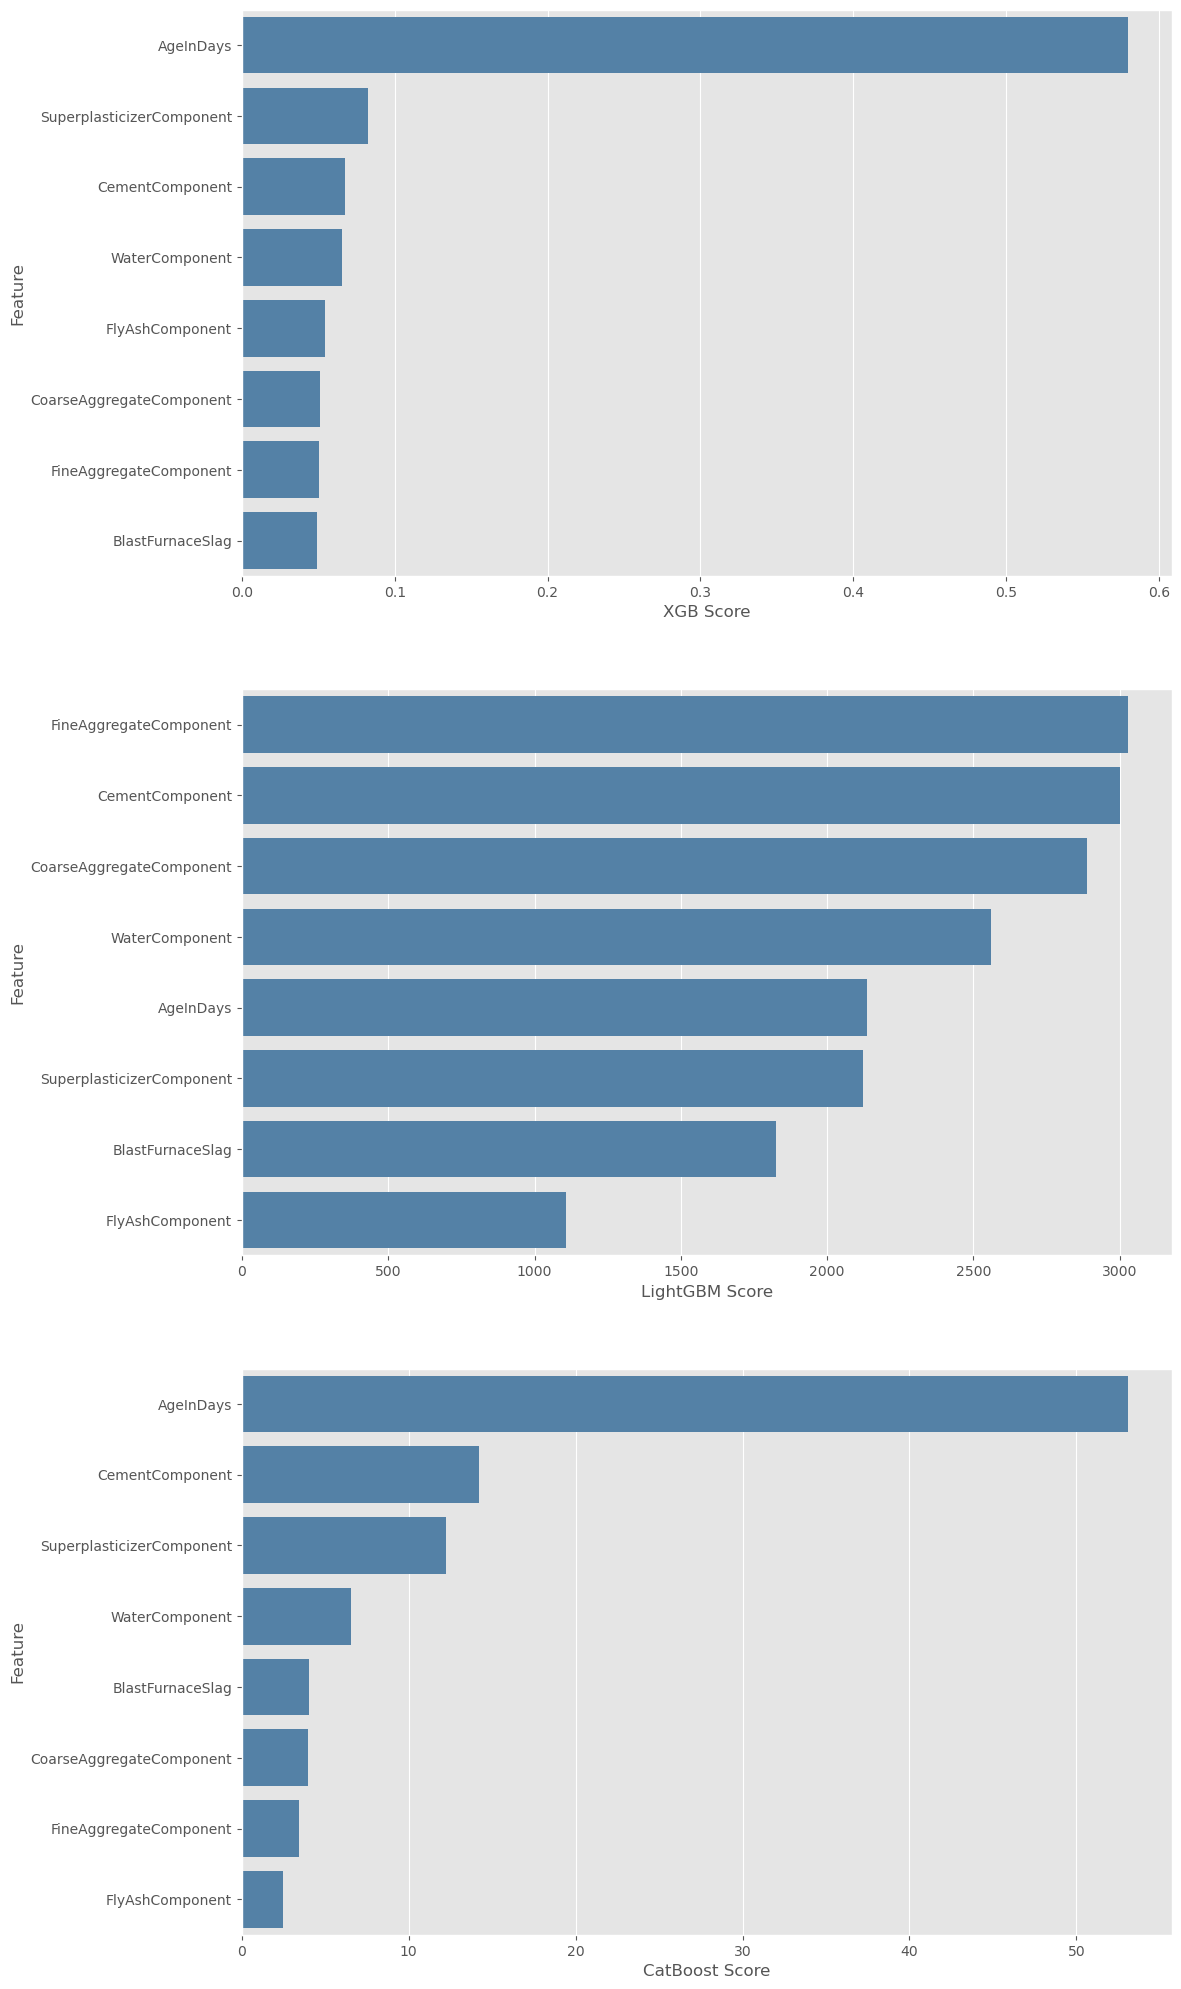

In [17]:
data1 = pd.DataFrame(pd.DataFrame(XGB_imp, columns = X.columns).apply(np.mean, axis = 0))
data1['Feature'] = data1.index
data1.columns = ['XGB Score', 'Feature']
data1.reset_index(drop = True, inplace = True)
data1.sort_values(by = 'XGB Score', ascending = False, inplace = True)

data2 = pd.DataFrame(pd.DataFrame(lgb_imp, columns = X.columns).apply(np.mean, axis = 0))
data2['Feature'] = data2.index
data2.columns = ['LightGBM Score', 'Feature']
data2.reset_index(drop = True, inplace = True)
data2.sort_values(by = 'LightGBM Score', ascending = False, inplace = True)

data3 = pd.DataFrame(pd.DataFrame(cat_imp, columns = X.columns).apply(np.mean, axis = 0))
data3['Feature'] = data3.index
data3.columns = ['CatBoost Score', 'Feature']
data3.reset_index(drop = True, inplace = True)
data3.sort_values(by = 'CatBoost Score', ascending = False, inplace = True)

fig, axes = plt.subplots(3, 1, figsize = (12, 25))
sns.barplot(ax = axes[0], data = data1, x = 'XGB Score', y = 'Feature', color = 'steelblue')
sns.barplot(ax = axes[1], data = data2, x = 'LightGBM Score', y = 'Feature', color = 'steelblue')
sns.barplot(ax = axes[2], data = data3, x = 'CatBoost Score', y = 'Feature', color = 'steelblue');

From the above, we see that `AgeInDays`, `CementComponent`, and `SuperplasticizerComponent` are among the most important features according to the boosting trees built-in feature importance score. Next, we proceed to store each model result and combine the results using a weighted average.

In [18]:
XGB_preds_test = pd.DataFrame(XGB_preds).apply(np.mean, axis = 0)
lgb_preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)
cat_preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)

submission['Strength'] = XGB_preds_test
submission.to_csv('XGB_baseline_submission.csv', index = False)

submission['Strength'] = lgb_preds_test
submission.to_csv('lgb_baseline_submission.csv', index = False)

submission['Strength'] = cat_preds_test
submission.to_csv('cat_baseline_submission.csv', index = False)

wtot = XGB_cv_score + lgb_cv_score + cat_cv_score
w_xgb = XGB_cv_score / wtot
w_lgb = lgb_cv_score / wtot
w_cat = cat_cv_score / wtot

submission['Strength'] = w_xgb*XGB_preds_test + w_lgb*lgb_preds_test + w_cat*cat_preds_test
submission.to_csv('weighted_avg_baseline_submission.csv', index = False)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline 2.0</h1>

In this section, we build a xgboost, lightgbm, and catboost models with raw features. However, in this case, we aggregate the target values of the duplicated observations in the train dataset.

In [19]:
train_no_dup = train.drop(columns = 'id', axis = 1)
train_no_dup = pd.DataFrame(train_no_dup.groupby(train_no_dup.columns.tolist()[0:8])['Strength'].mean()).reset_index()

X = train_no_dup.drop(columns = ['Strength'], axis = 1)
Y = train_no_dup['Strength']

test_baseline = test.drop(columns = ['id'], axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
XGB_preds = list()

lgb_cv_scores, lgb_imp = list(), list()
lgb_preds = list()

cat_cv_scores, cat_imp = list(), list()
cat_preds = list()

for i in range(5):

    skf = KFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        #############    
        ## XGBoost ##
        #############
        
        XGB_md = XGBRegressor(tree_method = 'gpu_hist',
                              colsample_bytree = 0.7, 
                              gamma = 0.8, 
                              learning_rate = 0.01, 
                              max_depth = 7, 
                              min_child_weight = 10, 
                              n_estimators = 1000, 
                              subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test_baseline)
        
        ## Computing rmse
        XGB_cv_scores.append(mean_squared_error(Y_test, XGB_pred_1, squared = False))
        XGB_preds.append(XGB_pred_2)
        
        ##############
        ## LightGBM ##
        ##############
        
        lgb_md = LGBMRegressor(n_estimators = 1000,
                               max_depth = 7,
                               learning_rate = 0.01,
                               num_leaves = 20,
                               lambda_l1 = 3,
                               lambda_l2 = 3,
                               bagging_fraction = 0.7,
                               feature_fraction = 0.7, 
                               device = 'gpu').fit(X_train, Y_train)
        lgb_imp.append(lgb_md.feature_importances_)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict(X_test)
        lgb_pred_2 = lgb_md.predict(test_baseline)
        
        ## Computing rmse
        lgb_cv_scores.append(mean_squared_error(Y_test, lgb_pred_1, squared = False))
        lgb_preds.append(lgb_pred_2)
        
        ##############
        ## CatBoost ##
        ##############
        
        cat_md = CatBoostRegressor(loss_function = 'RMSE',
                                   iterations = 1000,
                                   learning_rate = 0.01,
                                   depth = 7,
                                   random_strength = 0.5,
                                   bagging_temperature = 0.7,
                                   border_count = 30,
                                   l2_leaf_reg = 5,
                                   verbose = False,
                                   task_type = 'GPU').fit(X_train, Y_train)
        cat_imp.append(cat_md.feature_importances_)
        
        ## Predicting on X_test and test
        cat_pred_1 = cat_md.predict(X_test)
        cat_pred_2 = cat_md.predict(test_baseline)
        
        ## Computing rmse
        cat_cv_scores.append(mean_squared_error(Y_test, cat_pred_1, squared = False))
        cat_preds.append(cat_pred_2)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[Li

In [20]:
XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average oof rmse score over 5-folds (run 5 times) of the XGBoost model is:', XGB_cv_score)

lgb_cv_score = np.mean(lgb_cv_scores)    
print('The average oof rmse score over 5-folds (run 5 times) of the LightGBM model is:', lgb_cv_score)

cat_cv_score = np.mean(cat_cv_scores)    
print('The average oof rmse score over 5-folds (run 5 times) of the CatBoost model is:', cat_cv_score)

The average oof rmse score over 5-folds (run 5 times) of the XGBoost model is: 12.108292204642469
The average oof rmse score over 5-folds (run 5 times) of the LightGBM model is: 11.99571530362858
The average oof rmse score over 5-folds (run 5 times) of the CatBoost model is: 11.84525360625084


In [21]:
XGB_preds_test = pd.DataFrame(XGB_preds).apply(np.mean, axis = 0)
lgb_preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)
cat_preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)

submission['Strength'] = XGB_preds_test
submission.to_csv('XGB_baseline_2_submission.csv', index = False)

submission['Strength'] = lgb_preds_test
submission.to_csv('lgb_baseline_2_submission.csv', index = False)

submission['Strength'] = cat_preds_test
submission.to_csv('cat_baseline_2_submission.csv', index = False)

wtot = XGB_cv_score + lgb_cv_score + cat_cv_score
w_xgb = XGB_cv_score / wtot
w_lgb = lgb_cv_score / wtot
w_cat = cat_cv_score / wtot

submission['Strength'] = w_xgb*XGB_preds_test + w_lgb*lgb_preds_test + w_cat*cat_preds_test
submission.to_csv('weighted_avg_baseline_2_submission.csv', index = False)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline 3.0</h1>

In this section, we are going to build up from Baseline 2.0. We are still going to use the duplicates consolidation approach from baseline 2.0; however, in this case, we ensemble the three boosted model predictions in such a way that the out-of-fold root mean square error is minimized. In the following code block, we define the `OptimizedEnsemble` class that we will call later.

In [22]:
class OptimizedEnsemble(object):
    
    def __init__(self):
        self.coef_ = 0

    def _rmse_loss(self, coef, X, y):
        
        ens = coef[0]*X[:, 0] + coef[1]*X[:, 1] + coef[2]*X[:, 2]
        ll = mean_squared_error(y, ens, squared = False)
        return ll

    def fit(self, X, y):
        loss_partial = partial(self._rmse_loss, X = X, y = y)
        initial_coef = [1/3, 1/3, 1/3]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method = 'nelder-mead')

    def predict(self, X, coef):
        
        ens = coef[0]*X[:, 0] + coef[1]*X[:, 1] + coef[2]*X[:, 2]
        return ens

    def coefficients(self):
        return self.coef_['x']

Next, we proceed to run the cross-validation procedure using the `OptimizedEnsemble` class.

In [23]:
train_no_dup = train.drop(columns = 'id', axis = 1)
train_no_dup = pd.DataFrame(train_no_dup.groupby(train_no_dup.columns.tolist()[0:8])['Strength'].mean()).reset_index()

X = train_no_dup.drop(columns = ['Strength'], axis = 1)
Y = train_no_dup['Strength']

test_baseline = test.drop(columns = ['id'], axis = 1)

ens_cv_scores, preds = list(), list()

for i in range(5):

    skf = KFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        #############    
        ## XGBoost ##
        #############
        
        XGB_md = XGBRegressor(tree_method = 'gpu_hist',
                              colsample_bytree = 0.7, 
                              gamma = 0.8, 
                              learning_rate = 0.01, 
                              max_depth = 7, 
                              min_child_weight = 10, 
                              n_estimators = 1000, 
                              subsample = 0.7).fit(X_train, Y_train)
        
        ##############
        ## LightGBM ##
        ##############
        
        lgb_md = LGBMRegressor(n_estimators = 1000,
                               max_depth = 7,
                               learning_rate = 0.01,
                               num_leaves = 20,
                               lambda_l1 = 3,
                               lambda_l2 = 3,
                               bagging_fraction = 0.7,
                               feature_fraction = 0.7, 
                               device = 'gpu').fit(X_train, Y_train)
        
        ##############
        ## CatBoost ##
        ##############
        
        cat_md = CatBoostRegressor(loss_function = 'RMSE',
                                   iterations = 1000,
                                   learning_rate = 0.01,
                                   depth = 7,
                                   random_strength = 0.5,
                                   bagging_temperature = 0.7,
                                   border_count = 30,
                                   l2_leaf_reg = 5,
                                   verbose = False,
                                   task_type = 'GPU').fit(X_train, Y_train)

        ######################
        ## Optimal Ensemble ##
        ######################
        
        XGB_pred_1 = XGB_md.predict(X_test)
        lgb_pred_1 = lgb_md.predict(X_test)
        cat_pred_1 = cat_md.predict(X_test)
        models_pred_oof = np.transpose((XGB_pred_1, lgb_pred_1, cat_pred_1))

        opt_ens = OptimizedEnsemble()
        opt_ens.fit(models_pred_oof, Y_test)
        coef = opt_ens.coefficients()
        
        ens_pred = opt_ens.predict(models_pred_oof, coef)
        ens_cv_scores.append(mean_squared_error(Y_test, ens_pred, squared = False))
        
        XGB_pred_2 = XGB_md.predict(test_baseline)
        lgb_pred_2 = lgb_md.predict(test_baseline)
        cat_pred_2 = cat_md.predict(test_baseline)
        models_pred = np.transpose((XGB_pred_2, lgb_pred_2, cat_pred_2))
        
        ens_preds = opt_ens.predict(models_pred, coef)
        preds.append(ens_preds)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[Li

In [24]:
ens_cv_score = np.mean(ens_cv_scores)    
print('The average oof rmse score over 5-folds (run 5 times) of the ensemble model is:', ens_cv_score)


The average oof rmse score over 5-folds (run 5 times) of the ensemble model is: 11.81722029768247


In [25]:
ens_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

submission['Strength'] = ens_preds_test
submission.to_csv('Ensemble_baseline_submission.csv', index = False)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline 3.5</h1>

This is a follow up from baseline 3.0. The only big difference is that now we are using hyper-parameters obtained from the optuna framework.

In [26]:
train_no_dup = train.drop(columns = 'id', axis = 1)
train_no_dup = pd.DataFrame(train_no_dup.groupby(train_no_dup.columns.tolist()[0:8])['Strength'].mean()).reset_index()

X = train_no_dup.drop(columns = ['Strength'], axis = 1)
Y = train_no_dup['Strength']

test_baseline = test.drop(columns = ['id'], axis = 1)


In [27]:
ens_cv_scores, preds = list(), list()

for i in tqdm(range(5)):

    skf = KFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        #############    
        ## XGBoost ##
        #############
        
        XGB_md = XGBRegressor(tree_method = 'hist',
                              colsample_bytree = 0.671460244215802, 
                              gamma = 2.5281806276307384, 
                              learning_rate = 0.002046162779305807, 
                              max_depth = 8, 
                              min_child_weight = 80, 
                              n_estimators = 2690, 
                              subsample = 0.44886485549735244).fit(X_train, Y_train)
        
        ##############
        ## LightGBM ##
        ##############
        
        lgb_md = LGBMRegressor(n_estimators = 5420,
                               max_depth = 3,
                               learning_rate = 0.0014779400349972686,
                               num_leaves = 61,
                               lambda_l1 = 7.384172796287736,
                               lambda_l2 = 0.10456555506292783,
                               bagging_fraction = 0.22841166601766863,
                               feature_fraction = 0.659898030).fit(X_train, Y_train)
        
        ##############
        ## CatBoost ##
        ##############
        
        cat_md = CatBoostRegressor(loss_function = 'RMSE',
                                   iterations = 4738,
                                   learning_rate = 0.003143666241424718,
                                   depth = 4,
                                   random_strength = 0.29823973415192867,
                                   bagging_temperature = 0.3408793603898661,
                                   border_count = 112,
                                   l2_leaf_reg = 17,
                                   verbose = False).fit(X_train, Y_train)
        
        ######################
        ## Optimal Ensemble ##
        ######################
        
        XGB_pred_1 = XGB_md.predict(X_test)
        lgb_pred_1 = lgb_md.predict(X_test)
        cat_pred_1 = cat_md.predict(X_test)
        models_pred_oof = np.transpose((XGB_pred_1, lgb_pred_1, cat_pred_1))

        opt_ens = OptimizedEnsemble()
        opt_ens.fit(models_pred_oof, Y_test)
        coef = opt_ens.coefficients()
        
        ens_pred = opt_ens.predict(models_pred_oof, coef)
        ens_cv_scores.append(mean_squared_error(Y_test, ens_pred, squared = False))
        
        XGB_pred_2 = XGB_md.predict(test_baseline)
        lgb_pred_2 = lgb_md.predict(test_baseline)
        cat_pred_2 = cat_md.predict(test_baseline)
        models_pred = np.transpose((XGB_pred_2, lgb_pred_2, cat_pred_2))
        
        ens_preds = opt_ens.predict(models_pred, coef)
        preds.append(ens_preds)

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_fraction is set=0.22841166601766863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22841166601766863
[LightGBM] [Warning] lambda_l1 is set=7.384172796287736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.384172796287736
[LightGBM] [Warning] feature_fraction is set=0.65989803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65989803
[LightGBM] [Warning] lambda_l2 is set=0.10456555506292783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10456555506292783
[LightGBM] [Warning] bagging_fraction is set=0.22841166601766863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22841166601766863
[LightGBM] [Warning] lambda_l1 is set=7.384172796287736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.384172796287736
[LightGBM] [Warning] feature_fraction is set=0.65989803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65989803
[LightGBM] [Warning] lambda_

 20%|██        | 1/5 [00:43<02:54, 43.61s/it]

[LightGBM] [Warning] bagging_fraction is set=0.22841166601766863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22841166601766863
[LightGBM] [Warning] lambda_l1 is set=7.384172796287736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.384172796287736
[LightGBM] [Warning] feature_fraction is set=0.65989803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65989803
[LightGBM] [Warning] lambda_l2 is set=0.10456555506292783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10456555506292783
[LightGBM] [Warning] bagging_fraction is set=0.22841166601766863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22841166601766863
[LightGBM] [Warning] lambda_l1 is set=7.384172796287736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.384172796287736
[LightGBM] [Warning] feature_fraction is set=0.65989803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65989803
[LightGBM] [Warning] lambda_

 40%|████      | 2/5 [01:26<02:10, 43.45s/it]

[LightGBM] [Warning] bagging_fraction is set=0.22841166601766863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22841166601766863
[LightGBM] [Warning] lambda_l1 is set=7.384172796287736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.384172796287736
[LightGBM] [Warning] feature_fraction is set=0.65989803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65989803
[LightGBM] [Warning] lambda_l2 is set=0.10456555506292783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10456555506292783
[LightGBM] [Warning] bagging_fraction is set=0.22841166601766863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22841166601766863
[LightGBM] [Warning] lambda_l1 is set=7.384172796287736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.384172796287736
[LightGBM] [Warning] feature_fraction is set=0.65989803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65989803
[LightGBM] [Warning] lambda_

 60%|██████    | 3/5 [02:09<01:25, 42.99s/it]

[LightGBM] [Warning] bagging_fraction is set=0.22841166601766863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22841166601766863
[LightGBM] [Warning] lambda_l1 is set=7.384172796287736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.384172796287736
[LightGBM] [Warning] feature_fraction is set=0.65989803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65989803
[LightGBM] [Warning] lambda_l2 is set=0.10456555506292783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10456555506292783
[LightGBM] [Warning] bagging_fraction is set=0.22841166601766863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22841166601766863
[LightGBM] [Warning] lambda_l1 is set=7.384172796287736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.384172796287736
[LightGBM] [Warning] feature_fraction is set=0.65989803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65989803
[LightGBM] [Warning] lambda_

 80%|████████  | 4/5 [02:51<00:42, 42.69s/it]

[LightGBM] [Warning] bagging_fraction is set=0.22841166601766863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22841166601766863
[LightGBM] [Warning] lambda_l1 is set=7.384172796287736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.384172796287736
[LightGBM] [Warning] feature_fraction is set=0.65989803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65989803
[LightGBM] [Warning] lambda_l2 is set=0.10456555506292783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10456555506292783
[LightGBM] [Warning] bagging_fraction is set=0.22841166601766863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22841166601766863
[LightGBM] [Warning] lambda_l1 is set=7.384172796287736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.384172796287736
[LightGBM] [Warning] feature_fraction is set=0.65989803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65989803
[LightGBM] [Warning] lambda_

100%|██████████| 5/5 [03:33<00:00, 42.79s/it]


In [28]:
ens_cv_score = np.mean(ens_cv_scores)    
print('The average oof rmse score over 5-folds (run 5 times) of the ensemble model is:', ens_cv_score)

ens_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

submission['Strength'] = ens_preds_test
submission.to_csv('Ensemble_Optuna_baseline_submission.csv', index = False)

The average oof rmse score over 5-folds (run 5 times) of the ensemble model is: 11.773764812770375
